# **Clasificación de texto con Xlnet para ver si es phishing**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import XLNetTokenizer, TFXLNetModel
from tensorflow.keras.optimizers import Adam


c:\Users\Bryan\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Cargar el conjunto de datos
df = pd.read_csv('C:/Users/Bryan/codigo/Transformer_Phishing_Tesis/Data/phishing_dataset.csv')
df

,contexts,ham,phishing
0,google window google bypjtqaxxnab getei functi...,1,0
1,function envflush function window require requ...,1,0
2,timing timing timing tick function label time ...,1,0
3,yahoo deutschland roundtrip rttop number date ...,1,0
4,html overflow-y auto body font arial text-alig...,1,0
...,...,...,...
9756,crefisa function abrepopup janela window open ...,1,0
9757,welcome atbonline business page upgraded produ...,1,0
9758,window document location href internet browser...,1,0
9759,scam alert,1,0


In [4]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
xlnet_model = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(xlnet_model)

def encode_reviews(tokenizer, reviews, max_length=120):
    return tokenizer(reviews, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')

train_encodings = encode_reviews(tokenizer, train['contexts'].tolist())
test_encodings = encode_reviews(tokenizer, test['contexts'].tolist())


In [5]:
def create_model_xlnet(xlnet_model):
    word_inputs = tf.keras.Input(shape=(120,), dtype='int32', name='word_inputs')  # Ajusta el tamaño según tu configuración
    xlnet = TFXLNetModel.from_pretrained(xlnet_model)
    xlnet_encodings = xlnet(word_inputs)[0]
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    doc_encoding = tf.keras.layers.Dropout(0.1)(doc_encoding)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(doc_encoding)
    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(({
    'word_inputs': train_encodings['input_ids']
}, train['phishing'].values)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices(({
    'word_inputs': test_encodings['input_ids']
}, test['phishing'].values)).batch(32)


In [7]:
model = create_model_xlnet(xlnet_model)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=5)


c:\Users\Bryan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod

Epoch 1/5
244/244 [==============================] - 7430s 30s/step - loss: 0.3175 - accuracy: 0.8833 - val_loss: 0.2390 - val_accuracy: 0.8950
Epoch 2/5
244/244 [==============================] - 7386s 30s/step - loss: 0.2149 - accuracy: 0.9164 - val_loss: 0.1936 - val_accuracy: 0.9237
Epoch 3/5
244/244 [==============================] - 7382s 30s/step - loss: 0.1675 - accuracy: 0.9397 - val_loss: 0.1875 - val_accuracy: 0.9324
Epoch 4/5
244/244 [==============================] - 6849s 28s/step - loss: 0.1392 - accuracy: 0.9531 - val_loss: 0.1902 - val_accuracy: 0.9304
Epoch 5/5
244/244 [==============================] - 6428s 26s/step - loss: 0.1337 - accuracy: 0.9529 - val_loss: 0.1771 - val_accuracy: 0.9380


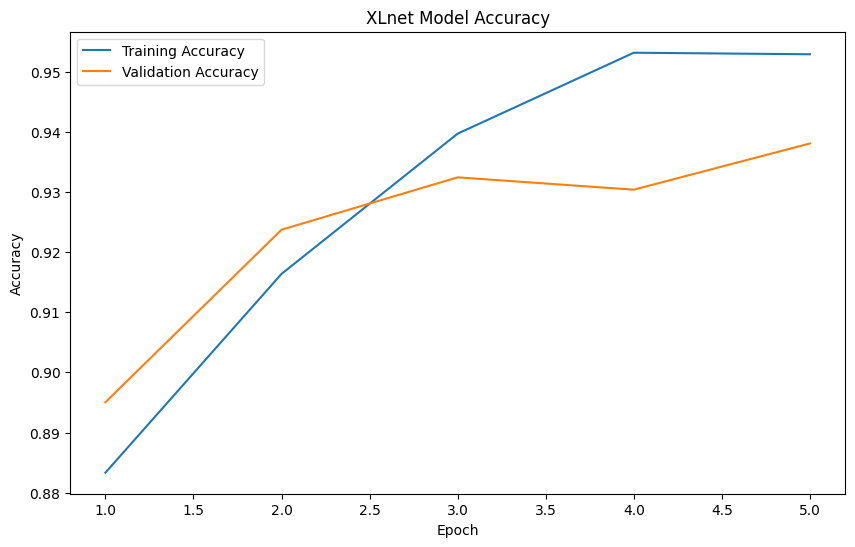

In [8]:
# La historia de entrenamiento contiene los registros de precisión para el entrenamiento y la validación
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
epochs = range(1, len(accuracy_train) + 1)

# Ahora puedes crear el gráfico utilizando Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy_train, label='Training Accuracy')
plt.plot(epochs, accuracy_val, label='Validation Accuracy')
plt.title('XLnet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
model.evaluate(test_dataset)


62/62 [==============================] - 371s 6s/step - loss: 0.1771 - accuracy: 0.9380


[0.17707234621047974, 0.938044011592865]

In [10]:
test_predictions = model.predict(test_dataset)


62/62 [==============================] - 353s 6s/step


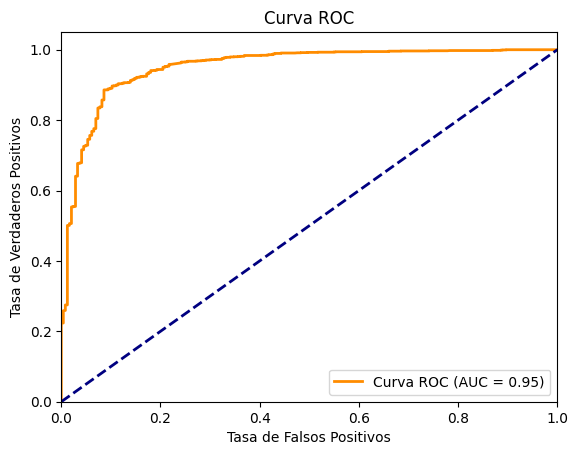

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Asumiendo que test['phishing'].values son tus etiquetas verdaderas
y_verdadero = test['phishing'].values

# Calcular los valores de la curva ROC y el área bajo la curva (AUC)
fpr, tpr, umbrales = roc_curve(y_verdadero, test_predictions)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


In [12]:
print(roc_auc)

0.9506733877543189


In [13]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Extraer las etiquetas verdaderas del dataset de prueba
# Necesitas asegurarte de que 'test' tiene las etiquetas en el mismo orden que 'test_dataset'
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Convertir las probabilidades predichas en etiquetas binarias
y_pred = np.round(test_predictions).astype(int).flatten()

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)


print("Matriz de Confusión:")
print(conf_matrix)


Matriz de Confusión:
[[ 179   65]
 [  56 1653]]


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score
predicted_labels = np.where(test_predictions > 0.5, 1, 0).flatten()
# Suponiendo que test['phishing'].values es un array numpy de etiquetas verdaderas
true_labels = test['phishing'].values

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Precision: 0.9621653084982538
Recall: 0.9672322995904038
F1 Score: 0.9646921505690108


In [15]:
# Definir las matrices de confusión
matrices = [
    [[164, 80], [47, 1662]],
    [[13, 915], [583, 6297]],
    [[130, 104], [55, 1664]],
    [[186, 58], [72, 1637]]
]

# Función para calcular TPR y FPR
def calcular_tpr_fpr(matrix):
    tp = matrix[0][0]
    fp = matrix[0][1]
    fn = matrix[1][0]
    tn = matrix[1][1]
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    return tpr, fpr

# Calcular TPR y FPR para cada matriz
resultados = [calcular_tpr_fpr(matrix) for matrix in matrices]

resultados


[(0.7772511848341233, 0.045924225028702644),
 (0.02181208053691275, 0.12687188019966722),
 (0.7027027027027027, 0.058823529411764705),
 (0.7209302325581395, 0.03421828908554572)]

In [16]:
model.save('XLNet_model.h5')